In [328]:
import random
import numpy as np
import math
from math import factorial, exp
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import poisson

%matplotlib inline

In [329]:
# Some stuff for formatting math
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

In [330]:
def lambert_w(z):
  """
  Lambert W function, principal branch.
  See http://en.wikipedia.org/wiki/Lambert_W_function
  Code taken from http://keithbriggs.info/software.html
  """
  eps=4.0e-16
  em1=0.3678794411714423215955237701614608
  assert(z>=-em1)
  if 0.0==z: 
      return 0.0
  if z<-em1+1e-4:
      q=z+em1
      r=math.sqrt(q)
      q2=q*q
      q3=q2*q
      return\
       -1.0\
       +2.331643981597124203363536062168*r\
       -1.812187885639363490240191647568*q\
       +1.936631114492359755363277457668*r*q\
       -2.353551201881614516821543561516*q2\
       +3.066858901050631912893148922704*r*q2\
       -4.175335600258177138854984177460*q3\
       +5.858023729874774148815053846119*r*q3\
       -8.401032217523977370984161688514*q3*q
  if z<1.0:
      p=math.sqrt(2.0*(2.7182818284590452353602874713526625*z+1.0))
      w=-1.0+p*(1.0+p*(-0.333333333333333333333+p*0.152777777777777777777777))
  else:
      w=math.log(z)
  if z>3.0: 
      w-=math.log(w)
  for i in range(10):
      e=math.exp(w)
      t=w*e-z
      p=w+1.0
      t/=e*p-0.5*(p+1.0)*t/p
      w-=t
      if abs(t)<eps*(1.0+abs(w)): 
          return w
  raise(AssertionError, 'Unhandled value %1.2f'%z)

def gamma_inverse(x):
  """
  Inverse the gamma function.
  http://mathoverflow.net/questions/12828/inverse-gamma-function
  """
  k=1.461632 # the positive zero of the digamma function, scipy.special.psi
  assert x>=k, 'gamma(x) is strictly increasing for x >= k, k=%1.2f, x=%1.2f' % (k, x)
  C=math.sqrt(2*np.pi)/np.e - scipy.special.gamma(k) # approximately 0.036534
  L=np.log((x+C)/np.sqrt(2*np.pi))
  gamma_inv = 0.5+L/lambert_w(L/np.e)
  return gamma_inv

In [331]:
def plot_func(func, x=np.linspace(0,5,3001), logscale=False, ylim=[], xlabel='', ylabel=''):
    y = np.vectorize(func)(x)
    axes = plt.gca()
    if logscale: axes.set_yscale('log')
    if len(ylim) == 2: axes.set_ylim(ylim)
    if xlabel: axes.set_xlabel(xlabel)
    if ylabel: axes.set_ylabel(ylabel)
    plt.title(func.__name__)
    plt.plot(x, y)
    plt.show()

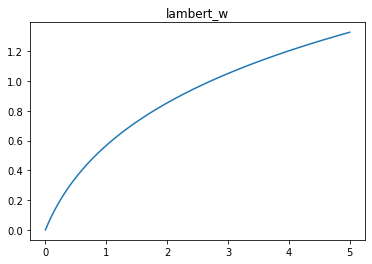

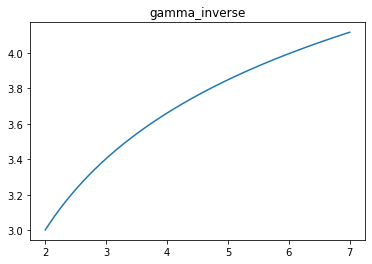

In [332]:
plot_func(lambert_w)
plot_func(gamma_inverse, x=np.linspace(2,7,30001))

In [333]:
def montecarlo_pdfmu0(method='ism'):
    # Generates variable on the distribution
    
    if method == 'ism':
        # Using inverse sampling method: 
        # https://en.wikipedia.org/wiki/Inverse_transform_sampling#The_method

        # CDF is 
        # We need to calulate inverse of CDF for eqn49
        # https://www.wolframalpha.com/input/?i=e%5E%28-x%2F2%29%2Fsqrt%288%5Cpi+x%29%2Bdelta%28x%29%2F2%3Dy%2C+solve+x

        inp = 1.0 / 8 / math.pi / random.uniform(0,1) ** 2
        return lambert_w(inp)
    
    elif method == 'nd':
        # For n=1, we can just square a number generated along the normal distribution
        # See page 8 of https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19830007824.pdf
        
        return 0.5 * np.random.normal(0, 1) ** 2

In [334]:
def delta(n):
    return 1 if n == 0 else 0

def pdfmu0(q_0):
    # Formula for pdf at mu0
    if q_0 < 1e-5: q_0 = 1e-5
    return (8 * math.pi * q_0) ** -0.5 * np.exp(-0.5 * q_0)

In [335]:
# Run it one time to see what we get
montecarlo_pdfmu0()

0.03889201995631454

In [336]:
def plot_distribution(dis, n=10_000, nbins=40, normalize=False, logscale=False, **kwargs):
    points = [dis(**kwargs) for i in range(n)]
    
    axes = plt.gca()
    plt.title(dis.__name__ + str(kwargs))
    if logscale: axes.set_yscale('log')
    if normalize:
        weights = np.ones_like(points)/float(len(points))
        plt.hist(points, nbins, weights=weights)
    else:
        plt.hist(points, nbins)
    plt.show()

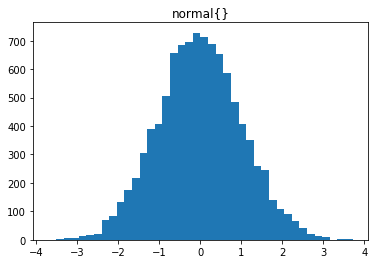

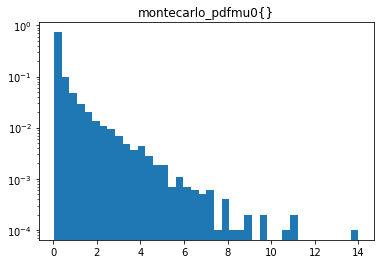

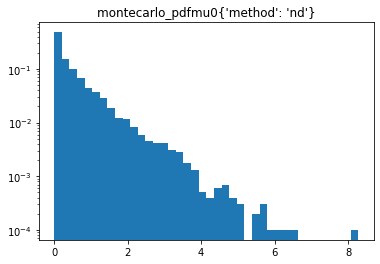

In [337]:
plot_distribution(np.random.normal)
plot_distribution(montecarlo_pdfmu0, normalize=True, logscale=True)
plot_distribution(montecarlo_pdfmu0, normalize=True, logscale=True, method='nd')

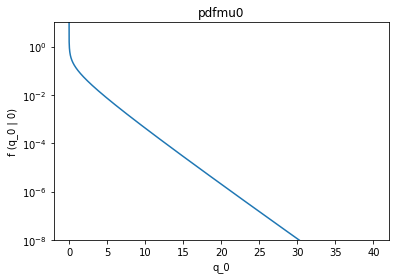

In [338]:
# Using eq49 to recreate black line in Fig 3(a)
plot_func(pdfmu0, logscale=True, x=np.linspace(0, 40, 40_000), 
          ylim=[10 ** -8, 10], xlabel='q_0', ylabel='f (q_0 | 0)')

In [339]:
b = 2
tau = 10
mu = 0
s = 10
GEN_NUM = 10_000

In [340]:
# Calculate (q, f(q_0|0)) for b = 2, 5, 20
E_m = tau * b
E_n = mu * s + b
print(f"E[m]: {E_m} E[n]: {E_n}")

# monte carlo generation *should* happen internally https://people.maths.ox.ac.uk/gilesm/talks/poisson_2013.pdf
# buts it's more likely scipy uses an estimate rather than the actual inverse CDF (which is slow to compute)
ms = [2 * poisson.ppf(random.uniform(0,1), E_m) for i in range(0, GEN_NUM)]
ns = [2 * poisson.ppf(random.uniform(0,1), E_n) for i in range(0, GEN_NUM)]

E[m]: 20 E[n]: 2


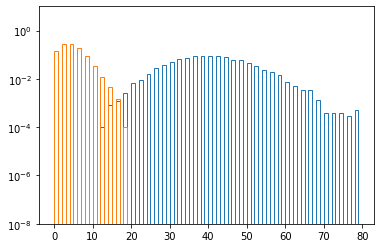

In [341]:
# Check n, m look ok
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
plt.hist(ms, bins=range(80), histtype='step', density=True)
plt.hist(ns, bins=range(80), histtype='step', density=True)
plt.show()

In [342]:
def likelihood(n, m, mu, b, tau):
    t1 = (mu * s + b) ** n / factorial(int(n)) * exp(b - mu * s)
    t2 = (tau * b) ** m / factorial(int(m)) * exp(-tau * b)
    return t1 * t2

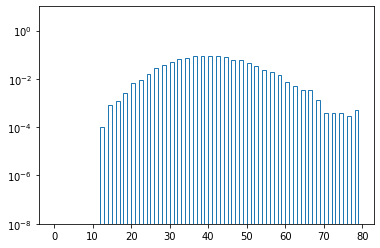

In [343]:
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
points = [likelihood(ns[i], ms[i], 0, b, tau) for i in range(GEN_NUM)]
plt.hist(ms, bins=range(80), histtype='step', density=True)
plt.show()

In [344]:
def mu_hat(n, m, s, tau):
    if s == 0: return 0
    return (n - m / tau) / s

def b_hat(m, tau):
    if tau == 0: return 0
    return m / tau

def b_2hat(n, m, mu, s):
    t1 = (n + m - (1 + tau) * mu * s) / 2 / (1 + tau)
    t2 = (n + m - (1 + tau * mu * s)) ** 2 + 4 * (1 + tau) * m * mu * s
    t2 /= 4 * (1 + tau) ** 2
    t2 **= 1 / 2
    return t1 + t2

In [345]:
print(mu_hat(ns[0], ms[0], s, tau))
print(b_hat(ms[0], tau))
print(b_2hat(ns[0], ms[0], mu, s))

0.18
4.2
4.318181818181818


In [346]:
def prof_likelihood_ratio(n, m, mu, s, tau):
    t1 = likelihood(n, m, mu, b_2hat(n, m, mu, s), tau)
    t2 = likelihood(n, m, mu_hat(n, m, s, tau), b_hat(m, tau), tau)
    return t1 / t2

def t_prof_likelihood_ratio(n, m, mu, s, tau):
    t1 = likelihood(n, m, mu, b_2hat(n, m, mu, s), tau)
    if mu_hat(n, m, s, tau) < 0:
        t2 = likelihood(n, m, 0, b_hat(0, tau), tau)
    else:
        t2 = likelihood(n, m, mu_hat(n, m, s, tau), b_hat(m, tau), tau)
    return t1 / t2

lambda_plr = prof_likelihood_ratio

0.9308192137947618


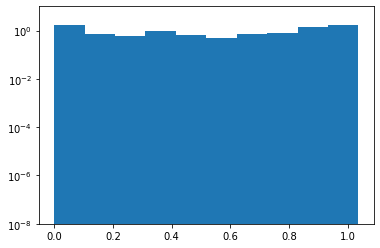

In [347]:
print(lambda_plr(ns[0], ms[0], mu, s, tau))
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
likelihoods = [lambda_plr(ns[i], ms[i], mu, s, tau) for i in range(GEN_NUM)]
plt.hist(likelihoods, density=True)
plt.show()

In [348]:
def get_q_0(n, m, s, tau):
    if mu_hat(n, m, s, tau) < 0: return 0
    return -2 * math.log(lambda_plr(n, m, 0, s, tau))

def get_q_mu(n, m, mu, s, tau):
    if mu_hat(n, m, s, tau) > mu: return 0
    return -2 * math.log(lambda_plr(n, m, mu, s, tau))

def get_t_q_mu(n, m, mu, s, tau):
    if mu_hat(n, m, s, tau) > mu: return 0
    return -2 * math.log(t_prof_likelihood_ratio(n, m, mu, s, tau))

In [349]:
print(get_q_0(ns[0], ms[0], s, tau))
print(get_q_mu(ns[0], ms[0], mu, s, tau))
print(get_t_q_mu(ns[0], ms[0], mu, s, tau))
# Results make sense since mu = 0, so q_0 = q_mu 
# and mu_hat >= 0 => lambda_plr == t_prof_likelihood_ratio => t_q_mu == q_mu

0.1433804110588888
0
0


In [350]:
print(get_q_0(ns[0], ms[0], s, tau))
print(get_q_mu(ns[0], ms[0], 0.7, s, tau))
print(pdfmu0(get_q_mu(ns[0], ms[0], 0.7, s, tau)))

0.1433804110588888
3.8086248642970326
0.015221715126476422


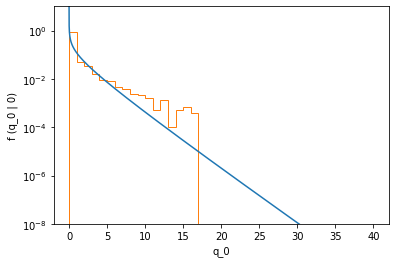

In [351]:
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlabel('q_0')
axes.set_ylabel('f (q_0 | 0)')
plt.rcParams["figure.figsize"] = [5, 5]

x = np.linspace(0, 40, 40_000)
pdfs = np.vectorize(pdfmu0)(x)
plt.plot(x, pdfs)

q_0s = [get_q_0(ns[i], ms[i], s, tau) for i in range(GEN_NUM)]
weights = np.ones_like(q_0s)/float(len(q_0s))
plt.hist(q_0s, bins=range(20), weights=weights, histtype='step')

plt.show()